# Data Import

In [127]:
# Mount Google drive to the coding space
#from google.colab import drive

#drive.mount('/content/drive/')

In [128]:
# Check if directory exist
#!ls "/content/drive/MyDrive/APS360/APS360_Group/data"

In [129]:
# Import Libraries
import torch
import os
import numpy as np
import pandas as pd

In [130]:
# Check if directory exist
#!ls "/content/drive/MyDrive/APS360/APS360_Group/data"


print("PyTorch version:", torch.__version__)
print("CUDA available? ", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    print("No GPU detected by PyTorch")

PyTorch version: 2.5.1+cu121
CUDA available?  True
GPU name: NVIDIA GeForce RTX 4060


In [131]:
# ---- Freeze external test (85) and build DEV pool (train/val/internal-test) ----
import pandas as pd, numpy as np
from pathlib import Path

LABELS_CSV = Path(r"C:/Users/namgy/OneDrive/Desktop/APS360-NEOFFI-Project/data/unrestricted_5_22_56_15.csv")
TEST85_NUM = Path(r"C:/Users/namgy/OneDrive/Desktop/APS360-NEOFFI-Project/data/unseen/test_ids_85_numeric.txt")

trait_columns = ['NEOFAC_A','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E']

# load labels (keep only rows with complete targets)
label_df_all = pd.read_csv(LABELS_CSV)
label_df_all['Subject'] = label_df_all['Subject'].astype(str)
label_df_all = label_df_all.dropna(subset=trait_columns)

# load the 85 numeric IDs
test_ids = set([ln.strip() for ln in TEST85_NUM.read_text(encoding='utf-8').splitlines() if ln.strip()])

# split: external TEST (85) vs DEV (everything else)
labels_test     = label_df_all[label_df_all['Subject'].isin(test_ids)].copy()
labels_trainval = label_df_all[~label_df_all['Subject'].isin(test_ids)].copy()

# guard + visibility
assert set(labels_test['Subject']).isdisjoint(labels_trainval['Subject']), "Leakage: overlap between test and dev!"
print(f"Total with labels: {len(label_df_all)} | Hold-out TEST (85): {len(labels_test)} | DEV: {len(labels_trainval)}")


Total with labels: 1199 | Hold-out TEST (85): 84 | DEV: 1115


In [172]:
# ---- Build label_map ONLY from DEV (train/val/internal-test) ----
label_df = labels_trainval.copy()  # <- comes from the cell above

trait_columns = ['NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E']
label_map = {
    row['Subject']: row[trait_columns].values.astype(np.float32)
    for _, row in label_df.iterrows()
}
print(f"label_map size (DEV only): {len(label_map)}")


label_map size (DEV only): 1115


# Dataset Initialization

In [173]:
# Dataset Class

from torch.utils.data import Dataset


class fconnDataset(Dataset):
    # Dataset Class
    def __init__(self, root_dir, target_network=None, label_map=None, transform=None):
        """
        Args:
            root_dir (str): Root directory with patient folders.
            target_network (int): Loads a specific network from each patient.
            label_map (dict): Mapping of patient IDs to labels.
            transform (callable): Optional transform to apply to each matrix.
        """
        self.root_dir = root_dir
        self.target_network = target_network
        self.label_map = label_map
        self.transform = transform

        valid_patients = []

        for patient_name in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient_name)
            patient_id = os.path.basename(patient_path).replace("subject_", "")
            # Only add patients with network data into valid_patients array
            if os.path.isdir(patient_path) and os.listdir(patient_path):
                # must have a label
                label = self.label_map.get(patient_id)
            if label is None:
                continue
            label = np.asarray(label, dtype=np.float32)
            
            if np.isnan(label).any():
                continue
            # must have the target network file
            file_path = os.path.join(patient_path, f"net_{self.target_network:02d}.npy")
            if not os.path.exists(file_path):
                continue
            valid_patients.append(patient_path)


        self.valid_patients = valid_patients

    def __len__(self):
        return len(self.valid_patients)

    def __getitem__(self, idx):
        patient_path = self.valid_patients[idx]
        patient_id = os.path.basename(patient_path).replace("subject_", "")

        file_path = os.path.join(patient_path, f"net_{self.target_network:02d}.npy")
        data = np.load(file_path)
        tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)  # [1, N, 10]

        if self.transform:
            tensor = self.transform(tensor)

        label_array = self.label_map.get(patient_id, np.full(5, np.nan, dtype=np.float32))
        label_tensor = torch.tensor(label_array, dtype=torch.float32)

        return tensor, label_tensor

    def getpatientid(self, idx):
        patient_path = self.valid_patients[idx]
        patient_id = os.path.basename(patient_path).replace("subject_", "")

        return patient_id

In [175]:
# Create dataset
# Around 2 min run time

dataset = fconnDataset(root_dir="C:/Users/namgy/OneDrive/Desktop/APS360-NEOFFI-Project/data/subjects", label_map=label_map,target_network=6)

# Standard 80% training, 10% validation, 10% test dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [176]:
# Check correlation

X = []
Y = []
for i in range(len(train_dataset)):
    #print(f'{i+1}/{len(train_dataset)}')
    x, y = train_dataset[i]
    X.append(x.reshape(-1).numpy())
    Y.append(y.numpy())

df_X = pd.DataFrame(X)
df_Y = pd.DataFrame(Y, columns=['A', 'O', 'C', 'N', 'E'])

for trait in df_Y.columns:
    correlations = df_X.corrwith(df_Y[trait])
    print(f"{trait} | Top correlations:\n", correlations.abs().sort_values(ascending=False).head(5))

A | Top correlations:
 3294    0.133659
4674    0.131200
4664    0.129788
3284    0.129011
474     0.128270
dtype: float64
O | Top correlations:
 4480    0.139936
4460    0.138997
4490    0.138779
1040    0.136697
1030    0.132560
dtype: float64
C | Top correlations:
 624     0.117689
4994    0.116391
2664    0.115785
3544    0.114845
1814    0.113492
dtype: float64
N | Top correlations:
 5008    0.135087
1618    0.131422
4148    0.131168
2708    0.130970
88      0.130037
dtype: float64
E | Top correlations:
 779     0.125746
1789    0.122470
2239    0.122306
3859    0.121888
3849    0.120819
dtype: float64


✅ Best network per trait (based on highest absolute correlation):

- A: Network 06 | Max Correlation: 0.3688
- O: Network 16 | Max Correlation: 0.3800
- C: Network 09 | Max Correlation: 0.4066
- N: Network 03 | Max Correlation: 0.3968
- E: Network 08 | Max Correlation: 0.3878

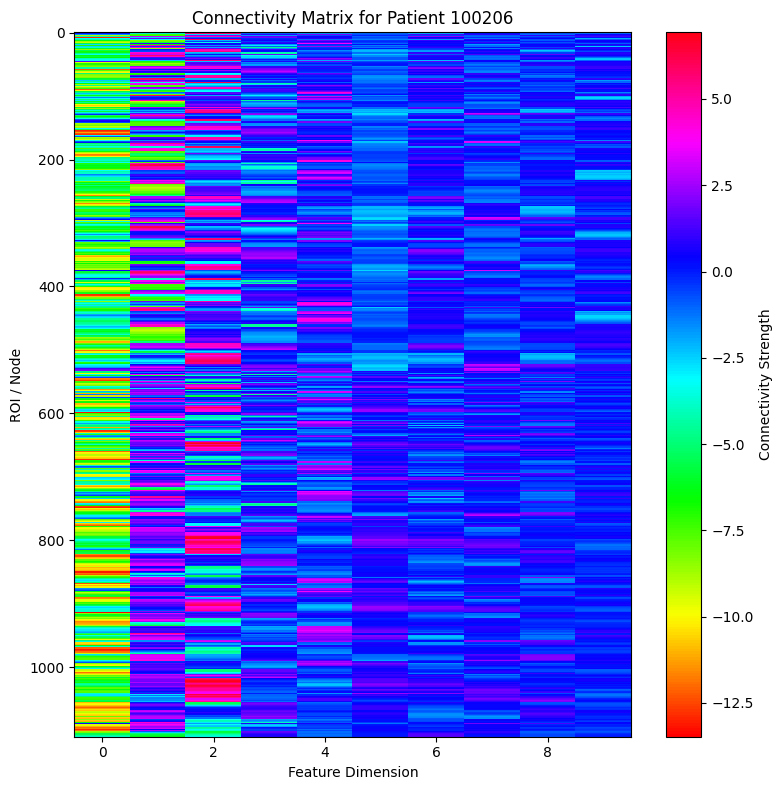

In [177]:
# Plot to ensure data is correct

import matplotlib.pyplot as plt
from matplotlib import colormaps
# Pick a sample (e.g., the 1st patient)
matrix, tensor = dataset[0]
patient_id = dataset.getpatientid(0)
matrix = matrix.squeeze(0)       # [N, 10]

plt.figure(figsize=(8, 8))
plt.imshow(matrix, cmap='hsv', aspect='auto', interpolation='none')
plt.colorbar(label='Connectivity Strength')
plt.title(f'Connectivity Matrix for Patient {patient_id}')
plt.xlabel("Feature Dimension")
plt.ylabel("ROI / Node")
plt.tight_layout()
plt.show()

# Hyperparameters

In [178]:
import torch.nn as nn
import torch.optim as optim

batch_size = 8
learning_rate = 3e-5
num_epochs = 60
N = dataset[0][0].shape[1] # Dimension of the Network [1, N, 10], extract region of interest (N)
momentum = 0.9
weight_decay = 1e-4
output_dim = 5

# Data Loader

In [179]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Training samples: 803
Validation samples: 100
Test samples: 101


In [180]:
from pathlib import Path
import os, numpy as np

ROOT = Path(r"C:/Users/namgy/OneDrive/Desktop/APS360-NEOFFI-Project/data/subjects")
TARGET_NETWORK = 8

# IDs from labels (DEV pool)
ids_labels = set(labels_trainval['Subject'].astype(str).tolist())

# IDs that actually exist as folders
ids_folders = {p.name.replace("subject_","") for p in ROOT.iterdir() if p.is_dir()}

# Which of those have the network file?
ids_with_file, ids_missing_file = set(), set()
for sid in ids_folders:
    p = ROOT / f"subject_{sid}" / f"net_{TARGET_NETWORK:02d}.npy"
    (ids_with_file if p.exists() else ids_missing_file).add(sid)

# Label map you used for DEV
lm = label_map  # built from labels_trainval

ids_with_label = {sid for sid in ids_with_file if sid in lm}
ids_nan_label  = {sid for sid in ids_with_label if np.isnan(np.asarray(lm[sid])).any()}
ids_usable     = ids_with_label - ids_nan_label

print("Labels (DEV pool)........:", len(ids_labels))
print("Folders on disk..........:", len(ids_folders))
print("Have net file............:", len(ids_with_file))
print("Have label+file..........:", len(ids_with_label))
print("NaN labels (filtered)....:", len(ids_nan_label))
print("USABLE (should equal dataset length):", len(ids_usable))

# Peek a few missing cases
print("\nExample missing net file:", sorted(list(ids_missing_file - ids_labels))[:10])
print("Example no label on DEV :", sorted(list(ids_with_file - ids_with_label))[:10])


Labels (DEV pool)........: 1115
Folders on disk..........: 1010
Have net file............: 1010
Have label+file..........: 1004
NaN labels (filtered)....: 0
USABLE (should equal dataset length): 1004

Example missing net file: []
Example no label on DEV : ['109830', '116120', '117728', '145531', '614439', '734247']


In [170]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor

def extract_features_labels(dataset):
    X = []
    Y = []
    for i in range(len(dataset)):
        x, y = dataset[i]
        X.append(x.reshape(-1).numpy())  # Flatten matrix to 1 dim
        Y.append(y.numpy())
    return np.array(X), np.array(Y)

X_train, Y_train = extract_features_labels(train_dataset)
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_val, Y_val = extract_features_labels(val_dataset)
X_test, Y_test = extract_features_labels(test_dataset)

X_train shape: (803, 10460)
Y_train shape: (803, 5)


# Baseline Model - Random Forest

In [171]:
random_forest = MultiOutputRegressor(RandomForestRegressor(n_estimators=5, random_state=42))
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)
mse = mean_squared_error(Y_test, Y_prediction)
r2 = r2_score(Y_test, Y_prediction)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 47.700039603960406
R² Score: -0.17537942406120247


# Training Functions

In [181]:
def evaluate(net, loader, criterion, device, return_r2=False, target_trait=None):
    net.eval()
    total_loss = 0.0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs, labels = inputs.to(device), labels.to(device)
            if target_trait is not None:
              labels = labels[:,target_trait]
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / (i + 1)

    if return_r2:
        from sklearn.metrics import r2_score
        all_outputs = torch.cat(all_outputs).numpy()
        all_labels = torch.cat(all_labels).numpy()
        r2 = r2_score(all_labels, all_outputs, multioutput='uniform_average')
        return avg_loss, r2

    return avg_loss

def train_model(net, train_loader, val_loader, criterion, optimizer, device, epochs=20, target_trait=None):
    best_val_loss = float('inf')
    best_model_state = None

    # Metric tracking lists
    train_losses = []
    val_losses = []
    val_r2s = []

    for epoch in range(1, epochs + 1):
        net.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            if target_trait is not None:
              labels = labels[:,target_trait]

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        avg_val_loss, val_r2 = evaluate(net, val_loader, criterion, device, return_r2=True, target_trait=target_trait)

        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_r2s.append(val_r2)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = net.state_dict()

        print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | R²: {val_r2:.4f}")

    # Restore best model
    if best_model_state is not None:
        net.load_state_dict(best_model_state)

    # Return model and metrics
    return net, train_losses, val_losses, val_r2s

# CNN Models

In [182]:
import torch.nn as nn

class fconnCNN(nn.Module):
    def __init__(self, N, output_dim):  # N = number of ROIs
        super().__init__()
        self.name = "fconnCNN"

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3), padding=1),  # [B, 16, N, 10]
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(2, 2)),                 # [B, 16, N//2, 5]

            nn.Conv2d(16, 32, kernel_size=(3, 3), padding=1), # [B, 32, N//2, 5]
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2)),                 # [B, 32, N//4, 2]

            nn.Conv2d(32, 64, kernel_size=(3, 2)),            # [B, 64, N//4 - 2, 1]
            nn.ReLU(),
        )

        # Compute the output shape dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, N, 10)  # [B=1, C=1, H=N, W=10]
            dummy_output = self.encoder(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).shape[1]

        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, 128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x # Squeeze for 1 trait, don't when computing regression on 5 traits


# Training

In [183]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device name: {torch.cuda.get_device_name(0)}")


CNN_model_0 = fconnCNN(N, output_dim=5).to(device)
# baseline_model = fconnBaseline(N, output_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(CNN_model_0.parameters(), lr=learning_rate, weight_decay=weight_decay)
trait_to_index = {
    "A": 0,  # Agreeableness
    "O": 1,  # Openness
    "C": 2,  # Conscientiousness
    "N": 3,  # Neuroticism
    "E": 4   # Extraversion
}
trained_model, train_losses, val_losses, val_r2s = train_model(
    CNN_model_0, train_loader, val_loader, criterion, optimizer, device, epochs=30
)

Using device: cuda
Device name: NVIDIA GeForce RTX 4060
Epoch 1/30 - Train Loss: 360.5727 | Val Loss: 77.8846 | R²: -1.0850
Epoch 2/30 - Train Loss: 81.3902 | Val Loss: 64.3091 | R²: -0.7164
Epoch 3/30 - Train Loss: 71.9808 | Val Loss: 54.2724 | R²: -0.4327
Epoch 4/30 - Train Loss: 66.0701 | Val Loss: 51.6952 | R²: -0.3514
Epoch 5/30 - Train Loss: 61.9441 | Val Loss: 45.8709 | R²: -0.1994
Epoch 6/30 - Train Loss: 57.5154 | Val Loss: 42.2211 | R²: -0.1054
Epoch 7/30 - Train Loss: 54.8025 | Val Loss: 42.7897 | R²: -0.1115
Epoch 8/30 - Train Loss: 53.6950 | Val Loss: 42.0652 | R²: -0.0910
Epoch 9/30 - Train Loss: 52.7922 | Val Loss: 42.4806 | R²: -0.0981
Epoch 10/30 - Train Loss: 54.4981 | Val Loss: 44.1675 | R²: -0.1499
Epoch 11/30 - Train Loss: 50.5197 | Val Loss: 41.3402 | R²: -0.0698
Epoch 12/30 - Train Loss: 50.4154 | Val Loss: 41.0775 | R²: -0.0634
Epoch 13/30 - Train Loss: 48.7667 | Val Loss: 45.5410 | R²: -0.1795
Epoch 14/30 - Train Loss: 47.6340 | Val Loss: 42.7925 | R²: -0.1090


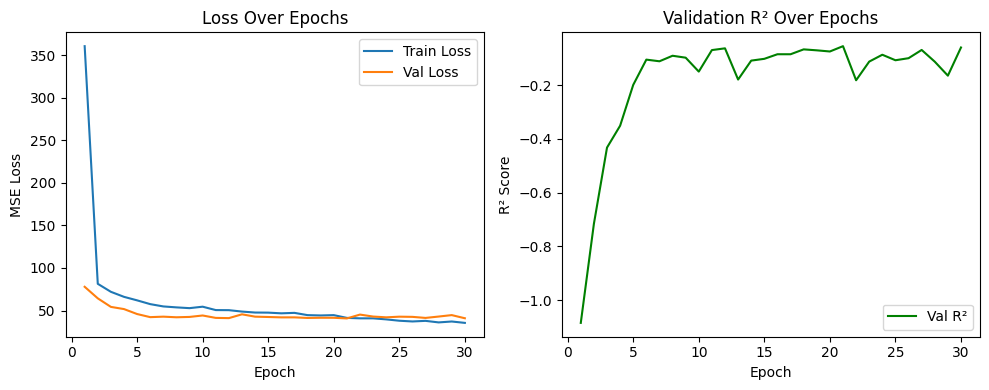

In [186]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_r2s, label='Val R²', color='green')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('Validation R² Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [207]:
# === Evaluate on external test set (uses your existing test_loader) ===
model = CNN_model_0.to(device)
model.eval()
test_mse, test_r2= evaluate(model, test_loader, criterion, device, return_r2=True)
print("Test Performance")
print(f"MSE: {test_mse}, R²: {test_r2}")


Test Performance
MSE: 42.83049647013346, R²: -0.01881415769457817


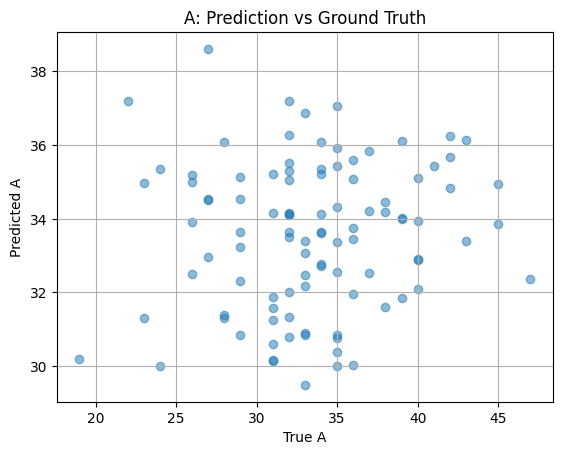

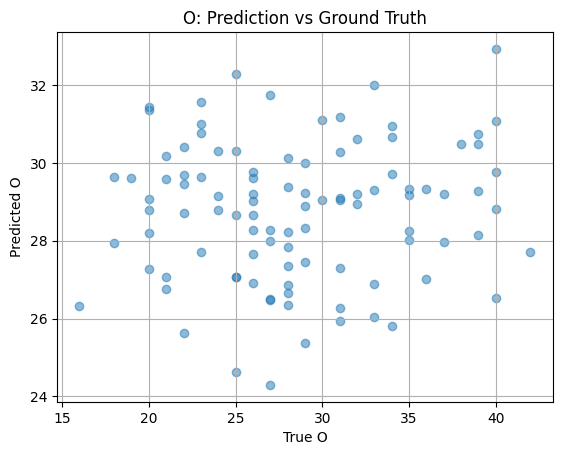

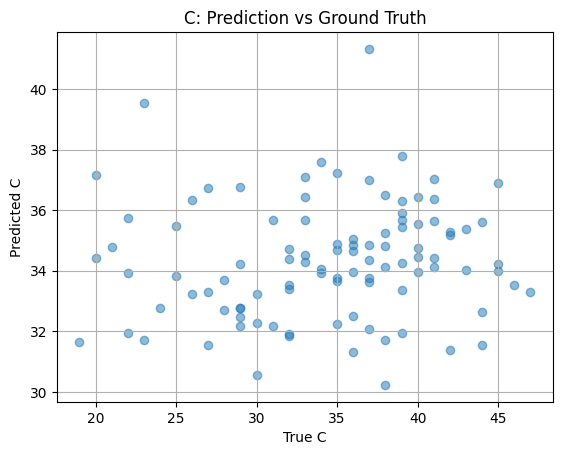

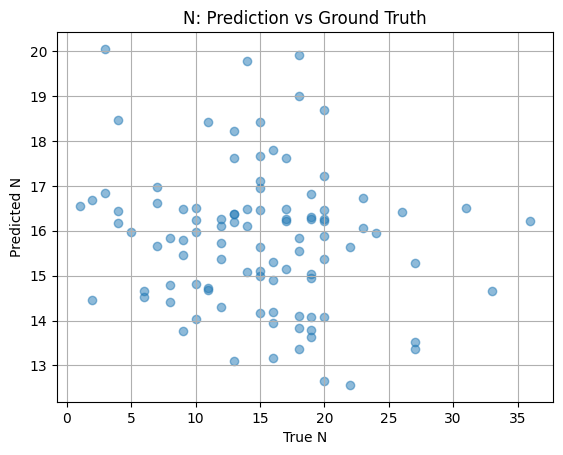

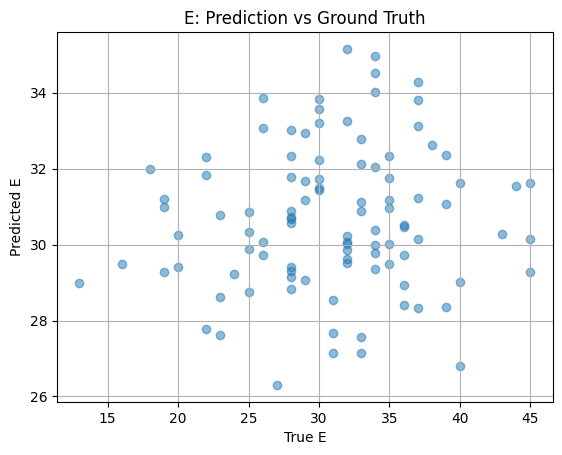

In [208]:
preds, labels = [], []
CNN_model_0.eval()
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        out = CNN_model_0(x)
        preds.append(out.cpu())
        labels.append(y.cpu())

preds = torch.cat(preds).numpy()
labels = torch.cat(labels).numpy()

for i, trait in enumerate(['A', 'O', 'C', 'N', 'E']):
    plt.scatter(labels[:, i], preds[:, i], alpha=0.5)
    plt.xlabel(f"True {trait}")
    plt.ylabel(f"Predicted {trait}")
    plt.title(f"{trait}: Prediction vs Ground Truth")
    plt.grid(True)
    plt.show()


In [189]:
# Save model weights 
torch.save(model.state_dict(), "model_weights.pth")
print("Model saved!")

Model saved!


# Evaluating Model on Unseen Data

In [194]:
# === Load model weights + eval on the 85 in data/unseen ===
WEIGHTS = r"C:/Users/namgy/OneDrive/Desktop/APS360-NEOFFI-Project/model_weights.pth"
TEST_ROOT = r"C:/Users/namgy/OneDrive/Desktop/APS360-NEOFFI-Project/data/unseen"
TARGET_NETWORK = 6
trait_columns = ['NEOFAC_A','NEOFAC_O','NEOFAC_C','NEOFAC_N','NEOFAC_E']

# Build label map for the 85 from your df
lm = label_test if 'label_test' in globals() else labels_test
label_map_test = {
    row['Subject']: row[trait_columns].values.astype(np.float32)
    for _, row in lm.iterrows()
}


In [195]:
# Dataset + loader for the frozen 85
test_dataset_external = fconnDataset(root_dir=TEST_ROOT, label_map=label_map_test, target_network=TARGET_NETWORK)
test_loader = torch.utils.data.DataLoader(test_dataset_external, batch_size=32, shuffle=False)

# Load weights into your existing model var (CNN_model_0)
_state = torch.load(WEIGHTS, map_location=device)
try:
    # if you saved state_dict
    CNN_model_0.load_state_dict(_state, strict=False)
except Exception:
    # if you saved the whole model
    CNN_model_0 = _state


C:\Users\namgy\AppData\Local\Temp\ipykernel_32484\3820103297.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _state = torch.load(WEIGHTS, map_location=device)


In [201]:
CNN_model_0.to(device).eval()

# Evaluate with your function
test_mse, test_r2 = evaluate(CNN_model_0, test_loader, criterion, device, return_r2=True)  # add target_trait=... if your evaluate needs it
print(f"Unseen subjects: {len(test_dataset_external)}")
print(f"Test MSE: {test_mse}, Test R2: {test_r2}")

test_mae_res = evaluate_mae(CNN_model_0, test_loader, device)

mae_macro = test_mae_res["macro"]
mae_per   = test_mae_res["per_trait"]    
mae_A = mae_per.get("A")
mae_O = mae_per.get("O")
mae_C = mae_per.get("C")
mae_N = mae_per.get("N")
mae_E = mae_per.get("E")

print(f"MAE macro: {mae_macro:.3f} | A: {mae_A:.3f} O: {mae_O:.3f} C: {mae_C:.3f} N: {mae_N:.3f} E: {mae_E:.3f}")

Unseen subjects: 84
Test MSE: 42.83049647013346, Test R2: -0.01881415769457817
MAE macro: 5.211 | A: 4.726 O: 5.046 C: 5.320 N: 6.102 E: 4.862
